<a href="https://colab.research.google.com/github/UIUC-CS598-S23-TEAM139/23Spring-CS598-Final-Project/blob/main/psychotic_disorder_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import io

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt

# The deep learning model was trained using Keras functional API, 
# running on top of TensorFlow in Google Colaboratory online platform 
# with Python 3.6 notebook.
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model, Model, Sequential
from keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPool2D

# Import Files

**How to access to the dataset:**

Please go the Appendix A of the [paper](https://www.sciencedirect.com/science/article/pii/S2352914821000356#cebib0010) or download through this [link](https://www.sciencedirect.com/science/article/pii/S2352340917303487#ec0010):


*   In the section 'Extras', please click on 'Download all' to get the cvs file.
*   Click on 'Choose Files' to upload the csv file here.



In [ ]:
from google.colab import files
uploaded = files.upload()

Saving data.csv to data (1).csv


In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['data.csv']),encoding='cp1252')

In [ ]:
df

,sex,age,faNoily_status,religion,occupation,genetic,status,loss_of_parent,divorse,Injury,Spiritual_consult,Insominia,shizopherania,vascula_demetia,MBD,Bipolar,agecode
0,M,18,Yes,C,STUDENT,Yes,S,Yes,No,No,Yes,N,P,P,P,N,1
1,F,30,Yes,M,ARTISAN,Yes,S,Yes,No,Yes,Yes,P,P,P,N,N,1
2,M,22,Yes,C,STUDENT,No,S,No,No,No,Yes,P,P,P,N,P,1
3,M,35,No,M,ARTISAN,No,M,No,No,No,Yes,P,P,N,N,P,2
4,M,30,Yes,M,ARTISAN,Yes,M,No,No,No,Yes,P,P,P,P,P,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,F,73,Yes,M,RETIRED,Yes,S,Yes,No,No,Yes,P,N,P,N,P,3
496,F,50,No,M,ARTISAN,No,M,Yes,No,No,No,P,P,N,P,P,2
497,F,32,No,C,FORCE,No,M,No,No,No,Yes,N,P,P,P,N,2
498,M,13,Yes,C,STUDENT,No,S,Yes,No,No,No,N,P,N,N,N,1


In [ ]:
set(df['Bipolar'])

{'N', 'P'}

# Data Preprocessing

**Encode data**


*   The Negative or N values are encoded as 0 and the Positive or P values are encoded as 1.
*   Add 'target' column with all combinations with more than 6 occurrences.



In [ ]:
## Binary and One-hot encoding for categorial variables

# Encode 'sex' (M/F) into binary value
df['sex'].replace(['M', 'F'], [0, 1], inplace=True)

# Encode 'faNoily_status' (No/Yes) into binary value
df['faNoily_status'].replace(['No', 'Yes'], [0, 1], inplace=True)

# Encode 'genetic' (No/Yes) into binary value
df['genetic'].replace(['No', 'Yes'], [0, 1], inplace=True)

# Encode 'status' (S/M) into binary value
df['status'].replace(['S', 'M'], [0, 1], inplace=True)

# Encode 'loss_of_parent' (No/Yes) into binary value
df['loss_of_parent'].replace(['No', 'Yes'], [0, 1], inplace=True)

# Encode 'divorse' (No/Yes) into binary value
df['divorse'].replace(['No', 'Yes'], [0, 1], inplace=True)

# Encode 'Injury' (No/Yes) into binary value
df['Injury'].replace(['No', 'Yes'], [0, 1], inplace=True)

# Encode 'Spiritual_consult' (No/Yes) into binary value
df['Spiritual_consult'].replace(['No', 'Yes'], [0, 1], inplace=True)



# region
dum_religion = pd.get_dummies(df.religion, prefix='religion')
df = pd.concat([df, dum_religion], axis=1)
df.drop('religion', inplace=True, axis=1)

# occupation
dum_occ = pd.get_dummies(df.occupation, prefix='occupation')
df = pd.concat([df, dum_occ], axis=1)
df.drop('occupation', inplace=True, axis=1)

# agecode
dum_agecode = pd.get_dummies(df.agecode, prefix='agecode')
df = pd.concat([df, dum_agecode], axis=1)
df.drop('agecode', inplace=True, axis=1)



# Insominia (N/P)
df['Insominia'].replace(['N', 'P'], [0, 1], inplace=True)

# MBD (N/P)
df['MBD'].replace(['N', 'P'], [0, 1], inplace=True)

# Bipolar (N/P)
df['Bipolar'].replace(['N', 'P'], [0, 1], inplace=True)

# shizopherania (N/P)
df['shizopherania'].replace(['N', 'P'], [0, 1], inplace=True)

# vascula_demetia (N/P)
df['vascula_demetia'].replace(['N', 'P'], [0, 1], inplace=True)

data = df.copy()

data

,sex,age,faNoily_status,genetic,status,loss_of_parent,divorse,Injury,Spiritual_consult,Insominia,...,religion_O,occupation_ARTISAN,occupation_C/SERVANT,occupation_FORCE,occupation_RETIRED,occupation_STUDENT,occupation_UNEMPLYD,agecode_1,agecode_2,agecode_3
0,0,18,1,1,0,1,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
1,1,30,1,1,0,1,0,1,1,1,...,0,1,0,0,0,0,0,1,0,0
2,0,22,1,0,0,0,0,0,1,1,...,0,0,0,0,0,1,0,1,0,0
3,0,35,0,0,1,0,0,0,1,1,...,0,1,0,0,0,0,0,0,1,0
4,0,30,1,1,1,0,0,0,1,1,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1,73,1,1,0,1,0,0,1,1,...,0,0,0,0,1,0,0,0,0,1
496,1,50,0,0,1,1,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
497,1,32,0,0,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
498,0,13,1,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0


Our target variables are in this order: Insomnia, schizophrenia, vascular dementia, ADHD and Bi-polar disorder.

In [ ]:
df['target'] = df['Insominia'].astype(str) + df['shizopherania'].astype(str) + df['vascula_demetia'].astype(str) + df['MBD'].astype(str) + df['Bipolar'].astype(str)

df

,sex,age,faNoily_status,genetic,status,loss_of_parent,divorse,Injury,Spiritual_consult,Insominia,...,occupation_ARTISAN,occupation_C/SERVANT,occupation_FORCE,occupation_RETIRED,occupation_STUDENT,occupation_UNEMPLYD,agecode_1,agecode_2,agecode_3,target
0,0,18,1,1,0,1,0,0,1,0,...,0,0,0,0,1,0,1,0,0,01110
1,1,30,1,1,0,1,0,1,1,1,...,1,0,0,0,0,0,1,0,0,11100
2,0,22,1,0,0,0,0,0,1,1,...,0,0,0,0,1,0,1,0,0,11101
3,0,35,0,0,1,0,0,0,1,1,...,1,0,0,0,0,0,0,1,0,11001
4,0,30,1,1,1,0,0,0,1,1,...,1,0,0,0,0,0,1,0,0,11111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1,73,1,1,0,1,0,0,1,1,...,0,0,0,1,0,0,0,0,1,10101
496,1,50,0,0,1,1,0,0,0,1,...,1,0,0,0,0,0,0,1,0,11011
497,1,32,0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,01110
498,0,13,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0,01000


In [ ]:
# Paper page 9 - "As such, we removed all combinations with less than 6 occurrences."
df = df.groupby('target').filter(lambda x: len(x) > 6)

imbalanced_data = df.copy()
# we have 'target' for these values
del imbalanced_data['Insominia']
del imbalanced_data['shizopherania']
del imbalanced_data['vascula_demetia']
del imbalanced_data['MBD']
del imbalanced_data['Bipolar']

balanced_data = df.copy()
del balanced_data['target']

In [ ]:
imbalanced_data

,sex,age,faNoily_status,genetic,status,loss_of_parent,divorse,Injury,Spiritual_consult,religion_C,...,occupation_ARTISAN,occupation_C/SERVANT,occupation_FORCE,occupation_RETIRED,occupation_STUDENT,occupation_UNEMPLYD,agecode_1,agecode_2,agecode_3,target
0,0,18,1,1,0,1,0,0,1,1,...,0,0,0,0,1,0,1,0,0,01110
2,0,22,1,0,0,0,0,0,1,1,...,0,0,0,0,1,0,1,0,0,11101
3,0,35,0,0,1,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,11001
4,0,30,1,1,1,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,11111
5,1,86,1,0,1,1,0,0,1,1,...,0,0,0,1,0,0,0,0,1,01100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1,73,1,1,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,1,10101
496,1,50,0,0,1,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,11011
497,1,32,0,0,1,0,0,0,1,1,...,0,0,1,0,0,0,0,1,0,01110
498,0,13,1,0,0,1,0,0,0,1,...,0,0,0,0,1,0,1,0,0,01000


Use 'Insominia' data

In [ ]:
balanced_data['Insominia']

0      0
2      1
3      1
4      1
5      0
      ..
495    1
496    1
497    0
498    0
499    0
Name: Insominia, Length: 484, dtype: int64

# Balance dataset with SMOTE
Just try SMOTE


In [ ]:
# y = balanced_data.pop('Insominia')
# X = balanced_data

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# X_train  

,sex,age,faNoily_status,genetic,status,loss_of_parent,divorse,Injury,Spiritual_consult,shizopherania,...,agecode,C,M,O,ARTISAN,C/SERVANT,FORCE,RETIRED,STUDENT,UNEMPLYD
345,0,34,0,0,1,0,0,0,1,1,...,2,0,1,0,0,0,0,0,1,0
44,1,34,0,1,1,1,0,0,0,1,...,2,1,0,0,0,0,0,0,0,1
129,0,50,1,0,1,0,0,0,0,1,...,2,1,0,0,1,0,0,0,0,0
102,0,21,0,0,0,0,0,0,1,1,...,1,0,0,1,0,0,0,0,1,0
420,0,30,1,1,0,1,0,0,0,1,...,1,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,1,25,0,0,0,0,0,0,1,1,...,1,0,1,0,0,0,0,0,0,1
394,1,56,1,1,1,1,0,1,0,1,...,3,1,0,0,0,1,0,0,0,0
344,1,50,1,1,1,1,0,1,1,1,...,2,1,0,0,1,0,0,0,0,0
204,1,26,1,0,0,0,0,0,1,1,...,1,1,0,0,1,0,0,0,0,0


In [ ]:
# every sample had a total of 101 samples each
# smote = SMOTE(random_state=101)
# X_train_balance, y_train_balance = smote.fit_resample(X_train, y_train.values.ravel())
# X_train_balance

,sex,age,faNoily_status,genetic,status,loss_of_parent,divorse,Injury,Spiritual_consult,shizopherania,...,agecode,C,M,O,ARTISAN,C/SERVANT,FORCE,RETIRED,STUDENT,UNEMPLYD
0,0,34,0,0,1,0,0,0,1,1,...,2,0,1,0,0,0,0,0,1,0
1,1,34,0,1,1,1,0,0,0,1,...,2,1,0,0,0,0,0,0,0,1
2,0,50,1,0,1,0,0,0,0,1,...,2,1,0,0,1,0,0,0,0,0
3,0,21,0,0,0,0,0,0,1,1,...,1,0,0,1,0,0,0,0,1,0
4,0,30,1,1,0,1,0,0,0,1,...,1,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417,0,27,0,0,0,0,0,0,1,1,...,1,0,0,0,0,0,0,0,1,0
418,1,20,0,0,0,0,0,0,1,1,...,1,0,0,0,0,0,0,0,1,0
419,0,54,1,0,1,0,0,1,0,0,...,3,0,1,0,0,0,0,0,0,0
420,0,45,1,0,1,1,0,0,1,1,...,2,1,0,0,1,0,0,0,0,0


# Multi-Label Classification Model on dataset with class imbalance.

# Machine learning

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

Train a Multilayer Perceptron (MLP), Support Vector Machines (SVM), Random Forest (RF) and Decision Tree (DT) on the training data (which is 80% of the whole data). The four algorithms are evaluated on the test set (which is 20% of the sampled data). The accuracy and balanced accuracy are as presented in Table 3.

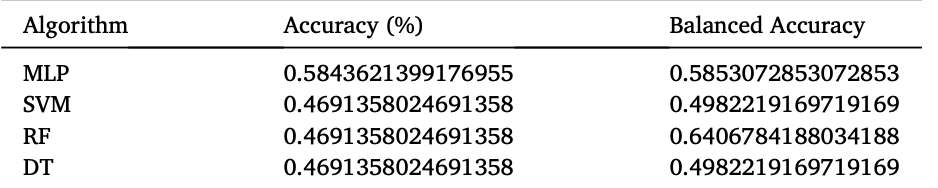


In [ ]:
temp = imbalanced_data.copy()
y_multi_imbalanced = temp.pop('target')
X_multi_imbalanced = temp
X_train, X_test, y_train, y_test = train_test_split(X_multi_imbalanced, y_multi_imbalanced, test_size=0.2)

In [ ]:
results = []

Multilayer Perceptron (MLP)

In [ ]:
MLP = MLPClassifier()
MLP.fit(X_train, y_train)
mlp_score = MLP.score(X_test, y_test)
results.append(f"Imbalanced data - MLP: {mlp_score}")
print(f"MLP for imbalanced data = {mlp_score}")

MLP for imbalanced data = 0.4742268041237113


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Support Vector Machines (SVM)

In [ ]:
svc = LinearSVC()
svc.fit(X_train, y_train)
svm_score = svc.score(X_test, y_test)
results.append(f"Imbalanced data - SVM: {svm_score}")
print(f"SVM for imbalanced data = {svm_score}")

SVM for imbalanced data = 0.26804123711340205


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Random Forest (RF)

In [ ]:
RF = RandomForestClassifier()
RF.fit(X_train, y_train)
rf_score = RF.score(X_test, y_test)
results.append(f"Imbalanced data - RF: {rf_score}")
print(f"RF for imbalanced data = {rf_score}")

RF for imbalanced data = 0.36082474226804123


Decision Tree (DT)

In [ ]:
decistion_tree = DecisionTreeClassifier()
decistion_tree.fit(X_train, y_train)
dt_score = decistion_tree.score(X_test, y_test)
results.append(f"Imbalanced data - DT: {dt_score}")
print(f"DT for imbalanced data = {dt_score}")

DT for imbalanced data = 0.32989690721649484


Deep learning using Neural Network


Use Neural Network in this paper:
https://keras.io/guides/sequential_model/

The architectural setup presented in Fig. 4a and b are 3-layer deep fully-connected network with the RELU activation function and architectural layer are 15–20–20-40–1 and 15-20–20-40–5 respectively. The training data is split into a 30% validation set running for 40 epochs with an early stop monitor on validation loss. The optimizer is Adam with a learning rate of 0.01.


*   Drop-out is chosen over L1 and L2 regularisation in this study
*   Sigmoid and ReLU is the activation function used in this study.
*   Optimizer is Adam with a learning rate of 0.01.
*   The loss function for training is a binary cross-entropy and evaluation metrics accuracy.



In [ ]:
def MultiLabelNN():
  # Create 3 layers
  # page 5 - Fig 4.
  # found shape=(10, 22)
  input = Dense(15, input_dim=22, activation="relu", name="Input")
  hidden_layer1 = Dense(20, activation="relu", name="layer1")
  hidden_layer2 = Dense(20, activation="relu", name="layer2") 
  hidden_layer3 = Dense(40, activation="relu", name="layer3") 
  output = Dense(5, activation="sigmoid", name="Output") 

  model = Sequential()

  model.add(input)
  model.add(Dropout(0.1))
  model.add(hidden_layer1)
  model.add(Dropout(0.1))
  model.add(hidden_layer2)
  model.add(Dropout(0.1))
  model.add(hidden_layer3)
  model.add(output)

  optimizer = keras.optimizers.Adam(learning_rate=0.01)
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  return model

In [ ]:
temp = df.copy()
y_multi_nn = pd.DataFrame([temp.pop(x) for x in ['Insominia', 'shizopherania', 'vascula_demetia', 'MBD', 'Bipolar']]).T

X_multi_nn = temp

# test
X_train, X_test, y_train, y_test = train_test_split(X_multi_nn, y_multi_nn, test_size=0.2)

# validation
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.3)

model = MultiLabelNN()
model.fit(
    tf.convert_to_tensor(np.asarray(X_train).astype('int')), 
    tf.convert_to_tensor(y_train),
    epochs=40, 
    batch_size=10
)

# test
test = model.evaluate(tf.convert_to_tensor(np.asarray(X_test).astype('int')), tf.convert_to_tensor(y_test), batch_size=10)

# validation
validation = model.evaluate(tf.convert_to_tensor(np.asarray(X_validation).astype('int')), tf.convert_to_tensor(y_validation), batch_size=10)

print(f'Training Loss and Accuracy (test): {test}')
print(f'Training Loss and Accuracy (validation): {validation}')
results.append(f"Imbalanced data - Multi-label NN Loss and Accuracy(test): {test}")
results.append(f"Imbalanced data - Multi-label NN Loss and Accuracy(validation): {validation}")

Epoch 1/40
27/27 [==============================] - 1s 3ms/step - loss: 36.2299 - accuracy: 0.3222
Epoch 2/40
27/27 [==============================] - 0s 2ms/step - loss: 1.6928 - accuracy: 0.4852
Epoch 3/40
27/27 [==============================] - 0s 3ms/step - loss: 0.9265 - accuracy: 0.5370
Epoch 4/40
27/27 [==============================] - 0s 3ms/step - loss: 0.8785 - accuracy: 0.5778
Epoch 5/40
27/27 [==============================] - 0s 2ms/step - loss: 0.6460 - accuracy: 0.5741
Epoch 6/40
27/27 [==============================] - 0s 2ms/step - loss: 0.6603 - accuracy: 0.5926
Epoch 7/40
27/27 [==============================] - 0s 3ms/step - loss: 0.6742 - accuracy: 0.5815
Epoch 8/40
27/27 [==============================] - 0s 2ms/step - loss: 0.6006 - accuracy: 0.5778
Epoch 9/40
27/27 [==============================] - 0s 2ms/step - loss: 0.6722 - accuracy: 0.5852
Epoch 10/40
27/27 [==============================] - 0s 2ms/step - loss: 0.6345 - accuracy: 0.5926
Epoch 11/40
27/27 

# Single-Label Classification Model on dataset with class imbalance
Using Neural Network with 3-layer

In [ ]:
def SingleLabelNN():
  # Create 3 layers
  # page 5 - Fig 4.
  # found shape=(10, 25)
  input = Dense(15, input_dim=25, activation="relu", name="Input")
  hidden_layer1 = Dense(20, activation="relu", name="layer1")
  hidden_layer2 = Dense(40, activation="relu", name="layer2") 
  hidden_layer3 = Dense(50, activation="relu", name="layer3") 
  output = Dense(1, activation="sigmoid", name="Output") 

  model = Sequential()

  model.add(input)
  model.add(Dropout(0.2))
  model.add(hidden_layer1)
  model.add(Dropout(0.2))
  model.add(hidden_layer2)
  model.add(Dropout(0.2))
  model.add(hidden_layer3)
  model.add(Dropout(0.2))
  model.add(output)

  optimizer = keras.optimizers.Adam(learning_rate=0.01)
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  return model

In [ ]:
diseases = ['Insominia', 'shizopherania', 'vascula_demetia', 'MBD', 'Bipolar']

losses = []

for d in diseases:
  X = data.copy()
  y = X.pop(d)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
  X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.3)

  model = SingleLabelNN()
  model.fit(
      tf.convert_to_tensor(np.asarray(X_train).astype('int')), 
      tf.convert_to_tensor(y_train),
      epochs=40, 
      batch_size=10
  )

  # test
  test = model.evaluate(tf.convert_to_tensor(np.asarray(X_test).astype('int')), tf.convert_to_tensor(y_test), batch_size=10)

  # validation
  validation = model.evaluate(tf.convert_to_tensor(np.asarray(X_validation).astype('int')), tf.convert_to_tensor(y_validation), batch_size=10)

  losses.append(f'{d} - Training Loss and Accuracy (test): {test}')
  losses.append(f'{d} - Training Loss and Accuracy (validation): {validation}')
  results.append(f"Imbalanced data - Single-label {d} NN Loss and Accuracy(test): {test}")
  results.append(f"Imbalanced data - Single-label {d} NN Loss and Accuracy(validation): {validation}")

for l in losses:
  print(l)

Epoch 1/40
28/28 [==============================] - 3s 2ms/step - loss: 0.8390 - accuracy: 0.5464
Epoch 2/40
28/28 [==============================] - 0s 2ms/step - loss: 0.6864 - accuracy: 0.5607
Epoch 3/40
28/28 [==============================] - 0s 3ms/step - loss: 0.6845 - accuracy: 0.6071
Epoch 4/40
28/28 [==============================] - 0s 3ms/step - loss: 0.6675 - accuracy: 0.5964
Epoch 5/40
28/28 [==============================] - 0s 3ms/step - loss: 0.6208 - accuracy: 0.6607
Epoch 6/40
28/28 [==============================] - 0s 2ms/step - loss: 0.6474 - accuracy: 0.6107
Epoch 7/40
28/28 [==============================] - 0s 2ms/step - loss: 0.5209 - accuracy: 0.7786
Epoch 8/40
28/28 [==============================] - 0s 2ms/step - loss: 0.3929 - accuracy: 0.8321
Epoch 9/40
28/28 [==============================] - 0s 2ms/step - loss: 0.3057 - accuracy: 0.9071
Epoch 10/40
28/28 [==============================] - 0s 2ms/step - loss: 0.1255 - accuracy: 0.9786
Epoch 11/40
28/28 [

# Multi-Label Classification Model on dataset without class imbalance

In [ ]:
temp = imbalanced_data.copy()
y_balanced = temp.pop('target')
X_balanced = temp
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2)

# balance data using SMOTE
smote = SMOTE()
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train.values.ravel())

Multilayer Perceptron (MLP)

In [ ]:
MLP = MLPClassifier()
MLP.fit(X_train_balanced, y_train_balanced)
mlp_score = MLP.score(X_test, y_test)
results.append(f"Balanced data - MLP: {mlp_score}")
print(f"MLP for balanced data = {mlp_score}")

MLP for balanced data = 0.3711340206185567


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Support Vector Machines (SVM)

In [ ]:
svc = LinearSVC()
svc.fit(X_train_balanced, y_train_balanced)
svm_score = svc.score(X_test, y_test)
results.append(f"Balanced data - SVM: {svm_score}")
print(f"SVM for balanced data = {svm_score}")

SVM for balanced data = 0.35051546391752575


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Random Forest (RF)

In [ ]:
RF = RandomForestClassifier()
RF.fit(X_train_balanced, y_train_balanced)
rf_score = RF.score(X_test, y_test)
results.append(f"Balanced data - RF: {rf_score}")
print(f"RF for balanced data = {rf_score}")

RF for balanced data = 0.3711340206185567


Decision Tree (DT)

In [ ]:
decistion_tree = DecisionTreeClassifier()
decistion_tree.fit(X_train_balanced, y_train_balanced)
dt_score = decistion_tree.score(X_test, y_test)
results.append(f"Balanced data - DT: {dt_score}")
print(f"DT for balanced data = {dt_score}")

DT for balanced data = 0.25773195876288657


Deep learning using Neural Network

In [ ]:
def MultiLabelNN():
  # Create 3 layers
  # page 5 - Fig 4.
  # found shape=(None, 21)
  input = Dense(15, input_dim=21, activation="relu", name="Input")
  hidden_layer1 = Dense(20, activation="relu", name="layer1")
  hidden_layer2 = Dense(20, activation="relu", name="layer2") 
  hidden_layer3 = Dense(40, activation="relu", name="layer3") 
  output = Dense(5, activation="sigmoid", name="Output") 

  model = Sequential()

  model.add(input)
  model.add(Dropout(0.1))
  model.add(hidden_layer1)
  model.add(Dropout(0.1))
  model.add(hidden_layer2)
  model.add(Dropout(0.1))
  model.add(hidden_layer3)
  model.add(output)

  optimizer = keras.optimizers.Adam(learning_rate=0.01)
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  return model

In [ ]:
from tensorflow.python.ops.gen_logging_ops import PrintV2

X_balanced_new, y_balanced_new = smote.fit_resample(X_balanced, y_balanced.values.ravel())

# Re-split the target column back into 5 diseases columns. 
separated_diseases = []
for value in y_balanced_new.ravel():
  item = []
  for v in value:
    item.append(v)
  separated_diseases.append(item)

y = pd.DataFrame(separated_diseases, columns = ['Insominia', 'shizopherania', 'vascula_demetia', 'MBD', 'Bipolar']).astype('int')


X_train, X_test, y_train, y_test = train_test_split(X_balanced_new, y, test_size=0.2)

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.3)

model = MultiLabelNN()
model.fit(
    tf.convert_to_tensor(np.asarray(X_train).astype('int')), 
    tf.convert_to_tensor(y_train),
    epochs=40, 
    batch_size=10
)

# test
test = model.evaluate(tf.convert_to_tensor(np.asarray(X_test).astype('int')), tf.convert_to_tensor(y_test), batch_size=10)

# validation
validation = model.evaluate(tf.convert_to_tensor(np.asarray(X_validation).astype('int')), tf.convert_to_tensor(y_validation), batch_size=10)

print(f'Training Loss and Accuracy (test): {test}')
print(f'Training Loss and Accuracy (validation): {validation}')

results.append(f"Balanced data - Multi-label NN Loss and Accuracy(test): {test}")
results.append(f"Balanced data - Multi-label NN Loss and Accuracy(validation): {validation}")

Epoch 1/40
68/68 [==============================] - 1s 3ms/step - loss: 0.7196 - accuracy: 0.3171
Epoch 2/40
68/68 [==============================] - 0s 3ms/step - loss: 0.6131 - accuracy: 0.3909
Epoch 3/40
68/68 [==============================] - 0s 3ms/step - loss: 0.5890 - accuracy: 0.4292
Epoch 4/40
68/68 [==============================] - 0s 3ms/step - loss: 0.5781 - accuracy: 0.4189
Epoch 5/40
68/68 [==============================] - 0s 3ms/step - loss: 0.5582 - accuracy: 0.4528
Epoch 6/40
68/68 [==============================] - 0s 3ms/step - loss: 0.5621 - accuracy: 0.4130
Epoch 7/40
68/68 [==============================] - 0s 3ms/step - loss: 0.5549 - accuracy: 0.4690
Epoch 8/40
68/68 [==============================] - 0s 3ms/step - loss: 0.5555 - accuracy: 0.4572
Epoch 9/40
68/68 [==============================] - 0s 3ms/step - loss: 0.5473 - accuracy: 0.4690
Epoch 10/40
68/68 [==============================] - 0s 3ms/step - loss: 0.5493 - accuracy: 0.4484
Epoch 11/40
68/68 [

# Single-Label Classification Model on dataset without class imbalance

In [ ]:
def SingleLabelNN():
  # Create 3 layers
  # page 5 - Fig 4.
  # found shape=(None, 25)
  input = Dense(15, input_dim=25, activation="relu", name="Input")
  hidden_layer1 = Dense(20, activation="relu", name="layer1")
  hidden_layer2 = Dense(40, activation="relu", name="layer2") 
  hidden_layer3 = Dense(50, activation="relu", name="layer3") 
  output = Dense(1, activation="sigmoid", name="Output") 

  model = Sequential()

  model.add(input)
  model.add(Dropout(0.4))
  model.add(hidden_layer1)
  model.add(Dropout(0.4))
  model.add(hidden_layer2)
  model.add(Dropout(0.4))
  model.add(hidden_layer3)
  model.add(Dropout(0.4))
  model.add(output)

  optimizer = keras.optimizers.Adam(learning_rate=0.01)
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  return model

In [ ]:
losses_balanced = []

for d in diseases:
  X = balanced_data.copy()
  y = X.pop(d)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
  X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.3)

  # balance data with SMOTE
  X_train, y_train = smote.fit_resample(X_train, y_train.values.ravel())
  X_validation, y_validation = smote.fit_resample(X_validation, y_validation.values.ravel())

  model = SingleLabelNN()
  model.fit(
      tf.convert_to_tensor(np.asarray(X_train).astype('int')), 
      tf.convert_to_tensor(y_train),
      epochs=40, 
      batch_size=10
  )

  # test
  test = model.evaluate(tf.convert_to_tensor(np.asarray(X_test).astype('int')), tf.convert_to_tensor(y_test), batch_size=10)

  # validation
  validation = model.evaluate(tf.convert_to_tensor(np.asarray(X_validation).astype('int')), tf.convert_to_tensor(y_validation), batch_size=10)

  losses_balanced.append(f'{d} - Training Loss and Accuracy (test): {test}')
  losses_balanced.append(f'{d} - Training Loss and Accuracy (validation): {validation}')

  results.append(f"Balanced data - Single-label {d} NN Loss and Accuracy(test): {test}")
  results.append(f"Balanced data - Single-label {d} NN Loss and Accuracy(validation): {validation}")

for l in losses_balanced:
  print(l)

Epoch 1/40
32/32 [==============================] - 1s 2ms/step - loss: 1.3440 - accuracy: 0.5281
Epoch 2/40
32/32 [==============================] - 0s 2ms/step - loss: 0.7153 - accuracy: 0.4563
Epoch 3/40
32/32 [==============================] - 0s 2ms/step - loss: 0.6821 - accuracy: 0.5406
Epoch 4/40
32/32 [==============================] - 0s 2ms/step - loss: 0.6721 - accuracy: 0.5688
Epoch 5/40
32/32 [==============================] - 0s 2ms/step - loss: 0.6599 - accuracy: 0.6531
Epoch 6/40
32/32 [==============================] - 0s 2ms/step - loss: 0.6362 - accuracy: 0.6562
Epoch 7/40
32/32 [==============================] - 0s 2ms/step - loss: 0.6046 - accuracy: 0.7125
Epoch 8/40
32/32 [==============================] - 0s 2ms/step - loss: 0.5621 - accuracy: 0.7625
Epoch 9/40
32/32 [==============================] - 0s 2ms/step - loss: 0.4652 - accuracy: 0.8094
Epoch 10/40
32/32 [==============================] - 0s 2ms/step - loss: 0.3567 - accuracy: 0.8813
Epoch 11/40
32/32 [

In [ ]:
print(results)

['Imbalanced data - MLP: 0.4742268041237113', 'Imbalanced data - SVM: 0.26804123711340205', 'Imbalanced data - RF: 0.36082474226804123', 'Imbalanced data - DT: 0.32989690721649484', 'Imbalanced data - Multi-label NN Loss and Accuracy(test): [0.6072657704353333, 0.5555555820465088]', 'Imbalanced data - Multi-label NN Loss and Accuracy(validation): [0.6072657704353333, 0.5555555820465088]', 'Imbalanced data - Single-label Insominia NN Loss and Accuracy(test): [6.406447482731892e-06, 1.0]', 'Imbalanced data - Single-label Insominia NN Loss and Accuracy(validation): [7.638313945790287e-06, 1.0]', 'Imbalanced data - Single-label shizopherania NN Loss and Accuracy(test): [0.0012753524351865053, 1.0]', 'Imbalanced data - Single-label shizopherania NN Loss and Accuracy(validation): [0.001699930289760232, 1.0]', 'Imbalanced data - Single-label vascula_demetia NN Loss and Accuracy(test): [0.00010099799692397937, 1.0]', 'Imbalanced data - Single-label vascula_demetia NN Loss and Accuracy(validati